# Data for Admission in the University: analisando modelos de Redes Neurais

## Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

---

## Importando os dados

In [2]:
data = pd.read_csv('adm_data.csv')  

#### Renomeando colunas para tirar espaços desnecessários e facilitar o acesso a elas

In [3]:
data.rename(columns = {'Chance of Admit ': 'Chance of Admit'}, inplace = True)
data.rename(columns = {'LOR ': 'LOR'}, inplace = True)

---

## Visualizando os dados

In [4]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


#### Retirando a coluna 'Serial No.', que não será utilizada

In [5]:
data1 = data.drop(columns = ['Serial No.'])

#### Definindo features e label

In [6]:
label = ['Chance of Admit']
features = list(set(data1.columns).difference(label))

In [7]:
features

['SOP',
 'TOEFL Score',
 'LOR',
 'GRE Score',
 'Research',
 'University Rating',
 'CGPA']

---

## Separando os dados

In [8]:
X = data[features]
y = data[label]

#### Split dos dados em train e test

In [9]:
random_state = 25
# Aqui o shuffling dos índices é automático.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

---

## Pré-processamento

#### Scaling nos dados para obter features no intervalo [0, 1]

In [10]:
X_train_scaled = (X_train - X_train.min())/(X_train.max() - X_train.min())
X_test_scaled = (X_test - X_train.min())/(X_train.max() - X_train.min())
# y_train e y_test já estão na escala correta, pois são probabilidades.
y_train_scaled = y_train
y_test_scaled = y_test

---

## Criando funções para nos ajudar a definir e treinar o modelo

In [11]:
def create_model(first_layer_units = 32, alpha = 0.1, reg_lambda = 0.1, features = [], random_seed = 0):
    '''Creates a defined model with learning rate = alpha.'''
    # Defining Tensorflow's random seed to generate reproducible results.
    tf.keras.utils.set_random_seed(random_seed)
    tf.config.experimental.enable_op_determinism()
    
    # We will be using Tensorflow's Sequencial API to build our model.
    model = tf.keras.models.Sequential()
    
    # Adding first layer with input_dim = number of features and relu activation function 
    # to learn some non-linearities. We will also add L2 regularization in layer's kernel (weights).
    model.add(tf.keras.layers.Dense(units = first_layer_units, input_shape = (len(features), ), 
                                   kernel_regularizer = tf.keras.regularizers.L2(l2 = reg_lambda),
                                   activation = 'relu'))
    
    # Adding output layer with linear activation (linear regression output).
    
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
    
    # Compiling model: selecting optimizer, loss and metrics.
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = alpha),
                 loss = 'mean_squared_error',
                 metrics = tf.keras.metrics.MeanSquaredError())
    
    return model

In [12]:
def train_model(model = None, X_train = None, y_train = None, epochs = 10,
               batch_size = 10, validation_split = 0.3,
               random_seed = 0):
    tf.keras.utils.set_random_seed(random_seed)
    tf.config.experimental.enable_op_determinism()
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size,
         epochs = epochs, shuffle = False, 
         validation_split = validation_split, verbose = 0)
    
    hist = pd.DataFrame(history.history)
    train_mse = np.array(hist['mean_squared_error'])
    if validation_split != 0:
        val_mse = np.array(hist['val_mean_squared_error'])
        return train_mse, val_mse
    return train_mse

In [13]:
def test_evaluation(model = None, X_test = None, y_test = None, batch_size = 10):
    return model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 0)

---

## Treinamento do modelo

### Definição dos hiperparâmetros

In [14]:
hp = {'first_layer_units': 64, 'epochs': 6, 'batch_size': 20, 'alpha': 0.001, 'reg_lambda': 0.1}

### Criação do modelo

In [15]:
model = create_model(first_layer_units = hp['first_layer_units'], alpha = hp['alpha'],
                     reg_lambda = hp['reg_lambda'], features = features, random_seed = random_state)

### Treino e validação de nosso primeiro modelo

In [16]:
val_split = 0.2

In [17]:
train_mse, val_mse = train_model(model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                 batch_size = hp['batch_size'], random_seed = random_state,
                                validation_split = val_split)

- Notamos um comportamento à primeira vista "estranho": os valores da função loss, que foi escolhida como mean_squared_error, está diferente da métrica mean_squared_error. Isso ocorre porque o cálculo de loss ocorre fazendo a média aritmética das somas dos quadrados dos erros e o cálculo da métrica ocorre fazendo a média ponderada desse valor.

In [18]:
print(train_mse[-1], val_mse[-1])

0.0059541319496929646 0.004728626925498247


In [19]:
test_evaluation(model, X_test_scaled, y_test_scaled, batch_size = hp['batch_size'])[1]

0.0057366820983588696

Parece que o modelo se saiu bem, pois os valores das métricas nos datasets de treino, validação e de teste estão muito próximas e bastante pequenas, chegando a valores próximos daqueles que obtivemos por meio do modelo de regressão linear feito from scratch. Notemos que o valor do mse dos dados de validação é consistentemente menor que dos dados de treino. Isso nos indica que o conjunto de dados é, de alguma forma, enviesado e os dados de validação escolhidos acabam sofrendo esse viés.

#### Agora que encontramos valores bons para os hiperparâmetros, vamos testar  a performance do modelo para vários valores de nodes na first layer do modelo, verificando como o resultado se comporta em função da complexidade.

In [20]:
unit_values = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [21]:
train_final_mse = {}
val_final_mse = {}
test_final_mse = {}
for first_layer_unit in unit_values:
    model = create_model(first_layer_units = first_layer_unit, alpha = hp['alpha'],
                     reg_lambda = hp['reg_lambda'], features = features, random_seed = random_state)
    train_mse, val_mse = train_model(model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                     batch_size = hp['batch_size'], random_seed = random_state)
    train_final_mse[first_layer_unit] = train_mse[-1]
    val_final_mse[first_layer_unit] = val_mse[-1]
    test_eval = test_evaluation(model, X_test_scaled, y_test_scaled, batch_size = hp['batch_size'])
    test_final_mse[first_layer_unit] = test_eval[1]

In [22]:
for unit in unit_values:
    print(f'{unit}:')
    print(f'Train final mse: {train_final_mse[unit]}')
    print(f'Val final mse: {val_final_mse[unit]}')
    print(f'Test final mse: {test_final_mse[unit]}')

2:
Train final mse: 0.26795366406440735
Val final mse: 0.2533721625804901
Test final mse: 0.2570023238658905
4:
Train final mse: 0.4653325378894806
Val final mse: 0.45149320363998413
Test final mse: 0.45909035205841064
8:
Train final mse: 0.38358116149902344
Val final mse: 0.3697211444377899
Test final mse: 0.3767125904560089
16:
Train final mse: 0.016293615102767944
Val final mse: 0.01586596854031086
Test final mse: 0.015151502564549446
32:
Train final mse: 0.010567734017968178
Val final mse: 0.009165219031274319
Test final mse: 0.00932895578444004
64:
Train final mse: 0.007368266116827726
Val final mse: 0.005644220393151045
Test final mse: 0.006550351623445749
128:
Train final mse: 0.005977165885269642
Val final mse: 0.005398815497756004
Test final mse: 0.005760280415415764
256:
Train final mse: 0.004738389514386654
Val final mse: 0.004140289034694433
Test final mse: 0.005410844925791025
512:
Train final mse: 0.006215388886630535
Val final mse: 0.007551521062850952
Test final mse: 0.

Vemos, através desse experimento, fatos curiosos:

- O valor do erro final do modelo tende a ser maior se temos um modelo exageradamente complexo, enquanto que modelos não tão complexo, o modelo performa relativamente bem. Isso acontece porque quando aumentamos a complexidade do modelo, ele tende a sofrer overfitting nos dados de treino, perdendo sua capacidade de generalização.

- Além disso, o valor "ótimo" de units é data-dependent, logo, não conseguimos prever antecipadamente qual dos valores de units será o melhor - apenas sabemos que não deve ser um valor extremamente grande, dado que estamos resolvendo um problema em que a regressão linear se encaixa muito bem devido às altas correlações das features com o target.

- Parece que o melhor valor foi 128, em termos de proximidades dos erros e de valores pequenos.

#### Note que as correlações entre a variável dependente (target) e as features são de fato elevadas:

In [23]:
def reconstruct_data(X, y):
    data = X.assign(Chance_of_admit  = y)
    data = data.rename(columns = {'Chance_of_admit': 'Chance of Admit'})
    return data

In [24]:
final_data = reconstruct_data(X_train, y_train)

In [25]:
final_data.corr()['Chance of Admit']

SOP                  0.674721
TOEFL Score          0.788699
LOR                  0.686924
GRE Score            0.796729
Research             0.517726
University Rating    0.713946
CGPA                 0.869127
Chance of Admit      1.000000
Name: Chance of Admit, dtype: float64

---

## Modelo selecionado

Para nosso modelo, escolheremos à primeira vista first_layer_units = 128, pois foi um modelo que performou bem e que mostrou poucos sinais de overfitting nos dados de treino com os hiperparâmetros selecionados.

In [26]:
hp['first_layer_units'] = 128

In [27]:
hp

{'first_layer_units': 128,
 'epochs': 6,
 'batch_size': 20,
 'alpha': 0.001,
 'reg_lambda': 0.1}

In [28]:
selected_model = create_model(first_layer_units = hp['first_layer_units'], alpha = hp['alpha'],
                     reg_lambda = hp['reg_lambda'], features = features, random_seed = random_state)

In [29]:
se_train_mse, se_val_mse = train_model(selected_model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                     batch_size = hp['batch_size'], random_seed = random_state)

In [30]:
se_test_eval = test_evaluation(selected_model, X_test_scaled, y_test_scaled, batch_size = hp['batch_size'])
print(f'\nMetrics for our selected linear regression model made with NN in Tensorflow Keras API:\n')
print(f'Selected model train mse: {se_train_mse[-1]}')
print(f'Selected model val mse: {se_val_mse[-1]}')
print(f'Selected model test mse: {se_test_eval[1]}')


Metrics for our selected linear regression model made with NN in Tensorflow Keras API:

Selected model train mse: 0.005977165885269642
Selected model val mse: 0.005398815497756004
Selected model test mse: 0.005760280415415764


#### Agora que temos nosso modelo, vamos analisar novamente se ele não sofre overfitting por meio de outra técnica, agora de cross-validation: K-fold.

In [31]:
hp

{'first_layer_units': 128,
 'epochs': 6,
 'batch_size': 20,
 'alpha': 0.001,
 'reg_lambda': 0.1}

In [32]:
def shuffle_data(data, random_state):
    '''Shuffles a Pandas Dataframe's data.'''
    rand = np.random.RandomState(random_state)
    return data.reindex(rand.permutation(data.index))

In [33]:
# KFold: k iterations in which (k-1) splits are for train and 1 for test.
def kfold_cross_validation(X = None, y = None, n_splits = 5, hp = {}, shuffle = True, random_state = 0):
    # Shuffling to avoid bias
    if shuffle:
        features = X.columns
        label = y.columns
        data = reconstruct_data(X, y)
        data = shuffle_data(data, random_state)
        X_shuffled = data[features]
        y_shuffled = data[label]
        
    kf = KFold(n_splits = n_splits)
    k_metrics = []
    for train_index, test_index in kf.split(X):
        X_train = X_shuffled.iloc[train_index].copy()
        y_train = y_shuffled.iloc[train_index].copy()
        X_test = X_shuffled.iloc[test_index].copy()
        y_test = y_shuffled.iloc[test_index].copy()
        
        # Scaling data:
        X_train_scaled = (X_train - X_train.min())/(X_train.max() - X_train.min())
        X_test_scaled = (X_test - X_train.min())/(X_train.max() - X_train.min())
        y_train_scaled = (y_train - y_train.min())/(y_train.max() - y_train.min())
        y_test_scaled = (y_test - y_train.min())/(y_train.max() - y_train.min())

        # Creating selected model:
        model = create_model(first_layer_units = hp['first_layer_units'], alpha = hp['alpha'],
                                        reg_lambda = hp['reg_lambda'], features = features, 
                                        random_seed = random_state)
        train_mse = train_model(model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                  batch_size = hp['batch_size'], random_seed = random_state,
                                  validation_split = 0)
        test_eval = test_evaluation(model, X_test_scaled, 
                                       y_test_scaled, batch_size = hp['batch_size'])
        metrics_list = [train_mse[-1], test_eval[1]]
        k_metrics.append(metrics_list)
        
    return k_metrics

In [34]:
n_splits = 5
k_metrics = kfold_cross_validation(X, y, n_splits = n_splits, shuffle = True,
                                   random_state = random_state, hp = hp)

In [35]:
def print_k_metrics(k_metrics):
    k = 0
    test_sum = 0
    for metrics in k_metrics:
        test_sum += metrics[1]
        print(f'\nMetrics for fold {k + 1}:\n')
        print(f'Selected model train mse: {metrics[0]}')
        print(f'Selected model test mse: {metrics[1]}')
        k += 1
    print(f'\n**** Test Mean Score: {test_sum/len(k_metrics)} ****')

In [36]:
print_k_metrics(k_metrics)


Metrics for fold 1:

Selected model train mse: 0.013096706941723824
Selected model test mse: 0.016073349863290787

Metrics for fold 2:

Selected model train mse: 0.012801393866539001
Selected model test mse: 0.01470155082643032

Metrics for fold 3:

Selected model train mse: 0.014096970669925213
Selected model test mse: 0.011816343292593956

Metrics for fold 4:

Selected model train mse: 0.013872802257537842
Selected model test mse: 0.012266437523066998

Metrics for fold 5:

Selected model train mse: 0.014333590865135193
Selected model test mse: 0.01116036344319582

**** Test Mean Score: 0.013203608989715575 ****


#### Os resultados do KFold estão mostrando que ainda ainda há um certo grau de overfitting, já que os mse do treino estão relativamente menores nos folds 1 e 2 em relação aos do teste. Então, podemos tentar melhorar esse resultado mudando alguns parâmetros.

Podemos tentar:

- Reduzir alpha
- Reduzir epochs
- Reduzir batch_size
- Aumentar reg_lambda

In [37]:
hp

{'first_layer_units': 128,
 'epochs': 6,
 'batch_size': 20,
 'alpha': 0.001,
 'reg_lambda': 0.1}

In [38]:
hp['reg_lambda'] = 0.16
hp['batch_size'] = 15
hp['alpha'] = 0.001/2
hp['epochs'] = 5

In [39]:
k_metrics = kfold_cross_validation(X, y, n_splits = n_splits, shuffle = True,
                                   random_state = random_state, hp = hp)

In [40]:
print_k_metrics(k_metrics)


Metrics for fold 1:

Selected model train mse: 0.013678397051990032
Selected model test mse: 0.01699281856417656

Metrics for fold 2:

Selected model train mse: 0.013694467954337597
Selected model test mse: 0.015372504480183125

Metrics for fold 3:

Selected model train mse: 0.015043574385344982
Selected model test mse: 0.012555333785712719

Metrics for fold 4:

Selected model train mse: 0.014952726662158966
Selected model test mse: 0.012930849567055702

Metrics for fold 5:

Selected model train mse: 0.015142167918384075
Selected model test mse: 0.012606320902705193

**** Test Mean Score: 0.014091565459966659 ****


In [41]:
hp

{'first_layer_units': 128,
 'epochs': 5,
 'batch_size': 15,
 'alpha': 0.0005,
 'reg_lambda': 0.16}

Apesar de tentarmos várias vezes mudar os hiperparâmetros, para o fold 2 não conseguimos aproximar o test mse do train mse. Além disso, há comportamentos anormais em todos os outros folds: os valores do train mse são maiores que do test mse. Isso indica que há viés nos dados, especialmente nesses folds. Uma maneira de tentarmos contornar esse "problema" seria aumentar o número de camadas do modelo ou o número de nodes por camada. Podemos também adicionar uma camada de dropout para evitar overfitting com o aumento de complexidade.

In [42]:
def create_model(first_layer_units = 32, alpha = 0.1, reg_lambda = 0.1, dropout_rate = 0, features = [], random_seed = 0):
    '''Creates a defined model with learning rate = alpha.'''
    # Defining Tensorflow's random seed to generate reproducible results.
    tf.keras.utils.set_random_seed(random_seed)
    tf.config.experimental.enable_op_determinism()
    
    # We will be using Tensorflow's Sequencial API to build our model.
    model = tf.keras.models.Sequential()
    
    # Adding first layer with input_dim = number of features and relu activation function 
    # to learn some non-linearities. We will also add L2 regularization in layer's kernel (weights).
    model.add(tf.keras.layers.Dense(units = first_layer_units, input_shape = (len(features), ), 
                                   kernel_regularizer = tf.keras.regularizers.L2(l2 = reg_lambda),
                                   activation = 'relu'))
    
    # Dropout layer
    
    model.add(tf.keras.layers.Dropout(rate = dropout_rate, seed = random_seed))
    
    model.add(tf.keras.layers.Dense(units = first_layer_units, input_shape = (len(features), ), 
                                    kernel_regularizer = tf.keras.regularizers.L2(l2 = reg_lambda)))
    
    # Adding output layer with linear activation (linear regression output).
    
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
    
    # Compiling model: selecting optimizer, loss and metrics.
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = alpha),
                 loss = 'mean_squared_error',
                 metrics = tf.keras.metrics.MeanSquaredError())
    
    return model

In [43]:
# KFold: k iterations in which (k-1) splits are for train and 1 for test.
def kfold_cross_validation(X = None, y = None, n_splits = 5, hp = {}, shuffle = True, random_state = 0):
    # Shuffling to avoid bias
    if shuffle:
        features = X.columns
        label = y.columns
        data = reconstruct_data(X, y)
        data = shuffle_data(data, random_state)
        X_shuffled = data[features]
        y_shuffled = data[label]
        
    kf = KFold(n_splits = n_splits)
    k_metrics = []
    for train_index, test_index in kf.split(X):
        X_train = X_shuffled.iloc[train_index].copy()
        y_train = y_shuffled.iloc[train_index].copy()
        X_test = X_shuffled.iloc[test_index].copy()
        y_test = y_shuffled.iloc[test_index].copy()
        
        # Scaling data:
        X_train_scaled = (X_train - X_train.min())/(X_train.max() - X_train.min())
        X_test_scaled = (X_test - X_train.min())/(X_train.max() - X_train.min())
        y_train_scaled = (y_train - y_train.min())/(y_train.max() - y_train.min())
        y_test_scaled = (y_test - y_train.min())/(y_train.max() - y_train.min())

        # Creating selected model:
        model = create_model(first_layer_units = hp['first_layer_units'], alpha = hp['alpha'],
                                        reg_lambda = hp['reg_lambda'], features = features, 
                                        random_seed = random_state, dropout_rate = hp['dropout_rate'])
        train_mse = train_model(model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                  batch_size = hp['batch_size'], random_seed = random_state,
                                  validation_split = 0)
        test_eval = test_evaluation(model, X_test_scaled, 
                                       y_test_scaled, batch_size = hp['batch_size'])
        metrics_list = [train_mse[-1], test_eval[1]]
        k_metrics.append(metrics_list)
        
    return k_metrics

In [44]:
hp['reg_lambda'] = 0.16
hp['batch_size'] = 15
hp['alpha'] = 0.001/2
hp['epochs'] = 5
hp['dropout_rate'] = 0.1

In [45]:
hp

{'first_layer_units': 128,
 'epochs': 5,
 'batch_size': 15,
 'alpha': 0.0005,
 'reg_lambda': 0.16,
 'dropout_rate': 0.1}

In [46]:
k_metrics = kfold_cross_validation(X, y, n_splits = n_splits, shuffle = True,
                                   random_state = random_state, hp = hp)

In [47]:
print_k_metrics(k_metrics)


Metrics for fold 1:

Selected model train mse: 0.023489098995923996
Selected model test mse: 0.02647761069238186

Metrics for fold 2:

Selected model train mse: 0.020654717460274696
Selected model test mse: 0.022453514859080315

Metrics for fold 3:

Selected model train mse: 0.022836241871118546
Selected model test mse: 0.0189454834908247

Metrics for fold 4:

Selected model train mse: 0.023396935313940048
Selected model test mse: 0.021287506446242332

Metrics for fold 5:

Selected model train mse: 0.02385631576180458
Selected model test mse: 0.0188724547624588

**** Test Mean Score: 0.021607314050197602 ****


- Note que adicionar novas camadas ao modelo, mesmo que ajustemos alguns parâmetros, aumentou o erro obtido e ainda não auxiliou na diminuição da diferença entre os mse de treino e de teste de forma tão satisfatória, pois o fold 1 ficou agora com uma grande diferença. Isso indica mais ainda que, em determinados folds, há, de fato, dados enviesados, mesmo que tenhamos embaralhado anteriormente o dataset. 

- O ideal nesse caso era termos mais dados para conseguirmos, com sorte, um modelo melhor. Em geral, o KFold não é uma boa forma de cross-validation para quando temos poucos dados.

- Nesse dataset em específico, aparentemente o modelo mais simples performou melhor, apesar dos comportamentos incomuns quanto aos erros.

---

## Análise final 

A última pergunta que fica é: se nenhum dos modelos mais complexos performou melhor, será que o modelo mais simples de regressão linear é suficiente para gerar um bom resultado? Vamos testar.

In [48]:
def create_simple_model(alpha = 0.1, features = [], random_seed = 0):
    '''Creates the simplest linear regression model.'''
    tf.keras.utils.set_random_seed(random_seed)
    tf.config.experimental.enable_op_determinism()
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(units = 1, input_dim = len(features)))
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = alpha),
                 loss = 'mean_squared_error',
                 metrics = tf.keras.metrics.MeanSquaredError())
    return model

In [49]:
def kfold_cv_simple_model(X = None, y = None, n_splits = 5, hp = {}, shuffle = True, random_state = 0):
    # Shuffling to avoid bias
    if shuffle:
        features = X.columns
        label = y.columns
        data = reconstruct_data(X, y)
        data = shuffle_data(data, random_state)
        X_shuffled = data[features]
        y_shuffled = data[label]
        
    kf = KFold(n_splits = n_splits)
    k_metrics = []
    for train_index, test_index in kf.split(X):
        X_train = X_shuffled.iloc[train_index].copy()
        y_train = y_shuffled.iloc[train_index].copy()
        X_test = X_shuffled.iloc[test_index].copy()
        y_test = y_shuffled.iloc[test_index].copy()
        
        # Scaling data:
        X_train_scaled = (X_train - X_train.min())/(X_train.max() - X_train.min())
        X_test_scaled = (X_test - X_train.min())/(X_train.max() - X_train.min())
        y_train_scaled = (y_train - y_train.min())/(y_train.max() - y_train.min())
        y_test_scaled = (y_test - y_train.min())/(y_train.max() - y_train.min())

        model = create_simple_model(alpha = hp['alpha'], features = features, 
                                    random_seed = random_state)
        train_mse = train_model(model, X_train_scaled, y_train_scaled, epochs = hp['epochs'], 
                                batch_size = hp['batch_size'], random_seed = random_state,
                                validation_split = 0)
        test_eval = test_evaluation(model, X_test_scaled, y_test_scaled, 
                                    batch_size = hp['batch_size'])
        metrics_list = [train_mse[-1], test_eval[1]]
        k_metrics.append(metrics_list)
        
    return k_metrics

In [50]:
hp['first_layer_units'] = 0
hp['epochs'] = 100
hp['batch_size'] = 5
hp['alpha'] = 0.002
hp['reg_lambda'] = 0
hp['dropout_rate'] = 0

In [51]:
simple_model_k_metrics = kfold_cv_simple_model(X, y, n_splits = n_splits, 
                                               hp = hp, shuffle = True, random_state = random_state)

In [52]:
print_k_metrics(simple_model_k_metrics)


Metrics for fold 1:

Selected model train mse: 0.010217291302978992
Selected model test mse: 0.010698268190026283

Metrics for fold 2:

Selected model train mse: 0.010046499781310558
Selected model test mse: 0.011491918936371803

Metrics for fold 3:

Selected model train mse: 0.010158227756619453
Selected model test mse: 0.011278880760073662

Metrics for fold 4:

Selected model train mse: 0.01027079951018095
Selected model test mse: 0.010511710308492184

Metrics for fold 5:

Selected model train mse: 0.01067424938082695
Selected model test mse: 0.008871487341821194

**** Test Mean Score: 0.010570453107357025 ****


A resposta é sim, conseguimos um resultado satisfatório para o problema e inclusive melhor que todos os outros modelos!

Um modelo mais simples de regressão linear conseguiu um fit melhor nesse caso. Podemos supor dois motivos:

- A alta correlação das features com o target fazem com que o modelo linear se adapte muito bem aos dados.

- A chance de overfitting aumenta quanto mais aumentamos a complexidade do modelo, gerando, assim, resultados piores nos dados de treino. Além disso, torna-se mais difícil de tunar os hiperparâmetros do modelo quando ele é muito complexo.

Para mostrarmos que nosso modelo funciona, também podemos testar o modelo de validação train-validation-test:

In [53]:
simple_model = create_simple_model(alpha = hp['alpha'], features = features, 
                                    random_seed = random_state)

In [54]:
train_mse, val_mse = train_model(simple_model, X_train_scaled, y_train_scaled, epochs = 100, validation_split = 0.2)

In [55]:
print(train_mse[-1], val_mse[-1])

0.00423893379047513 0.0035364676732569933


In [56]:
test_evaluation(simple_model, X_test_scaled, y_test_scaled, batch_size = hp['batch_size'])[1]

0.004316388163715601

Sim! O modelo performou muito bem nos dados de treino, estando longe do overfitting e apresentando um erro bem menor que nosso primeiro modelo (note que poderíamos diminuir o erro do primeiro modelo se aumentássemos o número de epochs, mas mesmo assim é difícil diminuir o erro tanto quanto conseguimos com o modelo mais simples). O erro menor nos dados de validação se deve a uma certa coincidência devido à distribuição dos dados.

Para terminar, vamos plotar em um gráfico os erros do treino e do teste nesse caso. Para isso, temos que adaptar as funções train_model para nos retornar as epochs:

In [57]:
def train_model_with_epochs(model = None, X_train = None, y_train = None, epochs = 10,
               batch_size = 10, validation_split = 0.3,
               random_seed = 0):
    tf.keras.utils.set_random_seed(random_seed)
    tf.config.experimental.enable_op_determinism()
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size,
         epochs = epochs, shuffle = False, 
         validation_split = validation_split, verbose = 0)
    
    hist = pd.DataFrame(history.history)
    train_mse = np.array(hist['mean_squared_error'])
    epochs = np.array(hist.index) + 1
    if validation_split != 0:
        val_mse = np.array(hist['val_mean_squared_error'])
        return train_mse, val_mse, epochs # adding epochs
    return train_mse, epochs # adding epochs

In [58]:
simple_model = create_simple_model(alpha = hp['alpha'], features = features, 
                                    random_seed = random_state)

In [59]:
train_mse, val_mse, epochs = train_model_with_epochs(simple_model, X_train_scaled, y_train_scaled, 
                                     epochs = hp['epochs'], validation_split = 0.2)

In [60]:
def plot_simple_model_errors(X_test, y_test, hp, random_state):
    features = X_test.columns
    simple_model = create_simple_model(alpha = hp['alpha'], features = features, 
                                    random_seed = random_state)
    train_mse, val_mse, epochs = train_model_with_epochs(simple_model, X_train_scaled, y_train_scaled, 
                                     epochs = hp['epochs'], validation_split = 0.2)
    test_eval = test_evaluation(simple_model, X_test, y_test, batch_size = hp['batch_size'])
    test_mse = [test_eval for i in epochs]
    plt.plot(epochs, train_mse, color = 'blue')
    plt.plot(epochs, val_mse, color = 'green')
    plt.plot(epochs, test_mse, color = 'red', linestyle = '--')
    plt.title('Simple Model Errors')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(['Train MSE', 'Validation MSE', 'Final Test MSE Line'])

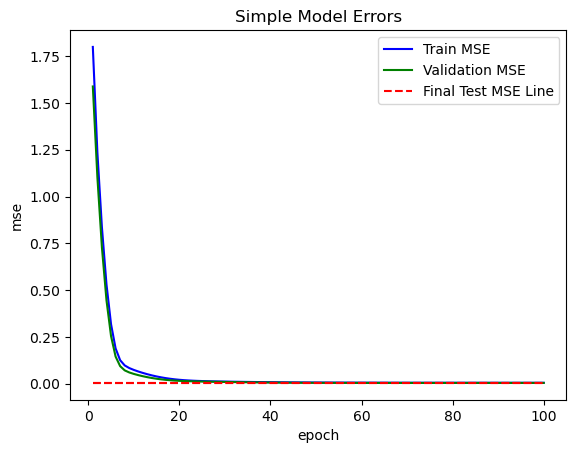

In [61]:
plot_simple_model_errors(X_test_scaled, y_test_scaled, hp, random_state)